<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/swin_transformer_with_mixup_and_various_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.4 MB/s eta 0:00:00


In [3]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW
from torchvision import transforms

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/image_RA'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_nonRA'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

In [4]:
batch_size=96
epochs = 300
lr = 0.05*3e-4
gamma = 0.8
seed = 42
#dropout_of_model('swin_base_patch4_window7_224.ms_in1k')
drop_rate=0.5
attn_drop_rate=0.4
drop_path_rate=0.4
mixup_alpha=0.4
#optimizer's_settings(AdamW)
weight_decay=6e-3
#scheduler's_settings(CosineAnnealingWarmRestarts)
T_0=100
T_mult=2
eta_min=1e-7

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=8),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.RandomPerspective(distortion_scale=0.12, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=drop_path_rate,
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

学習ループを設定し、実行していく

In [5]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=mixup_alpha)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            # Mixupを考慮した精度計算
            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()


        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list
# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model
# main関数も更新
def main():
    model = optimize_model_settings()
    train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = main()

<ipython-input-5-7c65355789dc>:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-5-7c65355789dc>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7286 - acc: 0.4679 - val_loss : 0.7696 - val_acc: 0.3021 - test_loss : 0.7031 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7449 - acc: 0.4792 - val_loss : 0.7621 - val_acc: 0.3021 - test_loss : 0.6985 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7080 - acc: 0.5058 - val_loss : 0.7502 - val_acc: 0.3021 - test_loss : 0.6930 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6607 - acc: 0.6416 - val_loss : 0.7415 - val_acc: 0.3021 - test_loss : 0.6887 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7164 - acc: 0.4486 - val_loss : 0.7308 - val_acc: 0.2917 - test_loss : 0.6847 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6951 - acc: 0.5237 - val_loss : 0.7234 - val_acc: 0.2969 - test_loss : 0.6813 - test_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6873 - acc: 0.5241 - val_loss : 0.7168 - val_acc: 0.3438 - test_loss : 0.6784 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6885 - acc: 0.5528 - val_loss : 0.7086 - val_acc: 0.4063 - test_loss : 0.6756 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6863 - acc: 0.5910 - val_loss : 0.7038 - val_acc: 0.4219 - test_loss : 0.6732 - test_acc: 0.5789



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6623 - acc: 0.6328 - val_loss : 0.6999 - val_acc: 0.4375 - test_loss : 0.6710 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6731 - acc: 0.5861 - val_loss : 0.7016 - val_acc: 0.4323 - test_loss : 0.6686 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6692 - acc: 0.5887 - val_loss : 0.7059 - val_acc: 0.4167 - test_loss : 0.6664 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6787 - acc: 0.5836 - val_loss : 0.7114 - val_acc: 0.4167 - test_loss : 0.6642 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6968 - acc: 0.5435 - val_loss : 0.7112 - val_acc: 0.4219 - test_loss : 0.6621 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6598 - acc: 0.5972 - val_loss : 0.7070 - val_acc: 0.4219 - test_loss : 0.6601 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6633 - acc: 0.5963 - val_loss : 0.7009 - val_acc: 0.4740 - test_loss : 0.6581 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6640 - acc: 0.5672 - val_loss : 0.6906 - val_acc: 0.4896 - test_loss : 0.6566 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6543 - acc: 0.6084 - val_loss : 0.6805 - val_acc: 0.5469 - test_loss : 0.6556 - test_acc: 0.5526



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6361 - acc: 0.6861 - val_loss : 0.6765 - val_acc: 0.5885 - test_loss : 0.6540 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6439 - acc: 0.6415 - val_loss : 0.6768 - val_acc: 0.5833 - test_loss : 0.6519 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6563 - acc: 0.5905 - val_loss : 0.6748 - val_acc: 0.5833 - test_loss : 0.6502 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6657 - acc: 0.5830 - val_loss : 0.6756 - val_acc: 0.5833 - test_loss : 0.6479 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6661 - acc: 0.5964 - val_loss : 0.6811 - val_acc: 0.5469 - test_loss : 0.6456 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6437 - acc: 0.6513 - val_loss : 0.6859 - val_acc: 0.5365 - test_loss : 0.6436 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6202 - acc: 0.6487 - val_loss : 0.6905 - val_acc: 0.5208 - test_loss : 0.6419 - test_acc: 0.5789



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6528 - acc: 0.6284 - val_loss : 0.6912 - val_acc: 0.5208 - test_loss : 0.6406 - test_acc: 0.5526



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6242 - acc: 0.6866 - val_loss : 0.6938 - val_acc: 0.5208 - test_loss : 0.6393 - test_acc: 0.5789



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6475 - acc: 0.6163 - val_loss : 0.6935 - val_acc: 0.5208 - test_loss : 0.6381 - test_acc: 0.5526



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6174 - acc: 0.6526 - val_loss : 0.6930 - val_acc: 0.5208 - test_loss : 0.6371 - test_acc: 0.5526



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6632 - acc: 0.6688 - val_loss : 0.6865 - val_acc: 0.5365 - test_loss : 0.6368 - test_acc: 0.5526



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6478 - acc: 0.6405 - val_loss : 0.6795 - val_acc: 0.5573 - test_loss : 0.6367 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6538 - acc: 0.6203 - val_loss : 0.6771 - val_acc: 0.5625 - test_loss : 0.6363 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.6357 - acc: 0.6198 - val_loss : 0.6725 - val_acc: 0.6042 - test_loss : 0.6361 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6618 - acc: 0.6195 - val_loss : 0.6709 - val_acc: 0.6458 - test_loss : 0.6357 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.6249 - acc: 0.6679 - val_loss : 0.6738 - val_acc: 0.5625 - test_loss : 0.6345 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5856 - acc: 0.7363 - val_loss : 0.6778 - val_acc: 0.5573 - test_loss : 0.6331 - test_acc: 0.5526



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5876 - acc: 0.7084 - val_loss : 0.6813 - val_acc: 0.5417 - test_loss : 0.6317 - test_acc: 0.5789



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6412 - acc: 0.6681 - val_loss : 0.6853 - val_acc: 0.5417 - test_loss : 0.6304 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6260 - acc: 0.6478 - val_loss : 0.6897 - val_acc: 0.5312 - test_loss : 0.6291 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6219 - acc: 0.6576 - val_loss : 0.6903 - val_acc: 0.5312 - test_loss : 0.6283 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6590 - acc: 0.6162 - val_loss : 0.6917 - val_acc: 0.5312 - test_loss : 0.6274 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5929 - acc: 0.6833 - val_loss : 0.6903 - val_acc: 0.5312 - test_loss : 0.6269 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6354 - acc: 0.6541 - val_loss : 0.6853 - val_acc: 0.5365 - test_loss : 0.6266 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5801 - acc: 0.7283 - val_loss : 0.6811 - val_acc: 0.5521 - test_loss : 0.6265 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.6051 - acc: 0.6774 - val_loss : 0.6775 - val_acc: 0.5573 - test_loss : 0.6265 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.6293 - acc: 0.6662 - val_loss : 0.6726 - val_acc: 0.5625 - test_loss : 0.6266 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.6186 - acc: 0.6812 - val_loss : 0.6674 - val_acc: 0.6094 - test_loss : 0.6270 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.6375 - acc: 0.6503 - val_loss : 0.6647 - val_acc: 0.6094 - test_loss : 0.6272 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.6454 - acc: 0.6518 - val_loss : 0.6618 - val_acc: 0.6146 - test_loss : 0.6278 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.6104 - acc: 0.7131 - val_loss : 0.6586 - val_acc: 0.6146 - test_loss : 0.6284 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.6033 - acc: 0.6838 - val_loss : 0.6583 - val_acc: 0.6562 - test_loss : 0.6282 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.6110 - acc: 0.6287 - val_loss : 0.6583 - val_acc: 0.6562 - test_loss : 0.6280 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.5695 - acc: 0.7593 - val_loss : 0.6603 - val_acc: 0.6094 - test_loss : 0.6270 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5866 - acc: 0.7070 - val_loss : 0.6620 - val_acc: 0.6042 - test_loss : 0.6260 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.5987 - acc: 0.7149 - val_loss : 0.6642 - val_acc: 0.6042 - test_loss : 0.6248 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.6535 - acc: 0.6621 - val_loss : 0.6652 - val_acc: 0.6042 - test_loss : 0.6238 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.6167 - acc: 0.6670 - val_loss : 0.6619 - val_acc: 0.6042 - test_loss : 0.6238 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.6312 - acc: 0.6594 - val_loss : 0.6551 - val_acc: 0.6458 - test_loss : 0.6249 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.6151 - acc: 0.6419 - val_loss : 0.6457 - val_acc: 0.6458 - test_loss : 0.6269 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5604 - acc: 0.7796 - val_loss : 0.6395 - val_acc: 0.6562 - test_loss : 0.6285 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5902 - acc: 0.7038 - val_loss : 0.6327 - val_acc: 0.6979 - test_loss : 0.6307 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5846 - acc: 0.7112 - val_loss : 0.6291 - val_acc: 0.6927 - test_loss : 0.6319 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.6094 - acc: 0.6787 - val_loss : 0.6269 - val_acc: 0.6823 - test_loss : 0.6325 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.5687 - acc: 0.7203 - val_loss : 0.6271 - val_acc: 0.6823 - test_loss : 0.6317 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.6457 - acc: 0.6228 - val_loss : 0.6287 - val_acc: 0.6927 - test_loss : 0.6300 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.5951 - acc: 0.7461 - val_loss : 0.6309 - val_acc: 0.6979 - test_loss : 0.6283 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5942 - acc: 0.6646 - val_loss : 0.6343 - val_acc: 0.6979 - test_loss : 0.6261 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.6079 - acc: 0.6950 - val_loss : 0.6360 - val_acc: 0.6615 - test_loss : 0.6247 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.6101 - acc: 0.6449 - val_loss : 0.6381 - val_acc: 0.6771 - test_loss : 0.6232 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.6102 - acc: 0.6473 - val_loss : 0.6392 - val_acc: 0.6823 - test_loss : 0.6223 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.6177 - acc: 0.6966 - val_loss : 0.6391 - val_acc: 0.6823 - test_loss : 0.6217 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.5973 - acc: 0.7164 - val_loss : 0.6390 - val_acc: 0.6823 - test_loss : 0.6210 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.5930 - acc: 0.7196 - val_loss : 0.6377 - val_acc: 0.6823 - test_loss : 0.6208 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.6010 - acc: 0.6986 - val_loss : 0.6365 - val_acc: 0.6771 - test_loss : 0.6206 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.6304 - acc: 0.6833 - val_loss : 0.6357 - val_acc: 0.6771 - test_loss : 0.6205 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.5847 - acc: 0.7484 - val_loss : 0.6342 - val_acc: 0.6719 - test_loss : 0.6205 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5682 - acc: 0.7186 - val_loss : 0.6323 - val_acc: 0.6719 - test_loss : 0.6209 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.6017 - acc: 0.7129 - val_loss : 0.6304 - val_acc: 0.7083 - test_loss : 0.6212 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.5755 - acc: 0.7003 - val_loss : 0.6287 - val_acc: 0.7031 - test_loss : 0.6217 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.6170 - acc: 0.6995 - val_loss : 0.6266 - val_acc: 0.7031 - test_loss : 0.6224 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.5901 - acc: 0.6995 - val_loss : 0.6248 - val_acc: 0.6927 - test_loss : 0.6230 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.6068 - acc: 0.6971 - val_loss : 0.6233 - val_acc: 0.6927 - test_loss : 0.6235 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.5871 - acc: 0.7069 - val_loss : 0.6225 - val_acc: 0.6875 - test_loss : 0.6238 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.5972 - acc: 0.7070 - val_loss : 0.6217 - val_acc: 0.6875 - test_loss : 0.6238 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.6121 - acc: 0.6925 - val_loss : 0.6214 - val_acc: 0.6875 - test_loss : 0.6237 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.5891 - acc: 0.7147 - val_loss : 0.6214 - val_acc: 0.6875 - test_loss : 0.6236 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.6099 - acc: 0.6767 - val_loss : 0.6212 - val_acc: 0.6875 - test_loss : 0.6235 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.6356 - acc: 0.6363 - val_loss : 0.6208 - val_acc: 0.6875 - test_loss : 0.6236 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.6039 - acc: 0.6938 - val_loss : 0.6205 - val_acc: 0.7240 - test_loss : 0.6237 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.6203 - acc: 0.6537 - val_loss : 0.6203 - val_acc: 0.7240 - test_loss : 0.6237 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.6517 - acc: 0.6253 - val_loss : 0.6202 - val_acc: 0.7240 - test_loss : 0.6237 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.6387 - acc: 0.6539 - val_loss : 0.6202 - val_acc: 0.7240 - test_loss : 0.6236 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.6459 - acc: 0.6432 - val_loss : 0.6201 - val_acc: 0.7240 - test_loss : 0.6236 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.5749 - acc: 0.7308 - val_loss : 0.6201 - val_acc: 0.7240 - test_loss : 0.6236 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5859 - acc: 0.6681 - val_loss : 0.6201 - val_acc: 0.7240 - test_loss : 0.6236 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.6205 - acc: 0.6773 - val_loss : 0.6202 - val_acc: 0.7240 - test_loss : 0.6235 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5900 - acc: 0.7268 - val_loss : 0.6202 - val_acc: 0.7240 - test_loss : 0.6234 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5487 - acc: 0.7739 - val_loss : 0.6203 - val_acc: 0.7240 - test_loss : 0.6233 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.6564 - acc: 0.6451 - val_loss : 0.6203 - val_acc: 0.7240 - test_loss : 0.6233 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5640 - acc: 0.7219 - val_loss : 0.6202 - val_acc: 0.7292 - test_loss : 0.6233 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.5799 - acc: 0.7133 - val_loss : 0.6227 - val_acc: 0.7083 - test_loss : 0.6184 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.6075 - acc: 0.6954 - val_loss : 0.6226 - val_acc: 0.6667 - test_loss : 0.6154 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.6066 - acc: 0.7011 - val_loss : 0.6191 - val_acc: 0.7083 - test_loss : 0.6144 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.6437 - acc: 0.6295 - val_loss : 0.6161 - val_acc: 0.7031 - test_loss : 0.6127 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.6055 - acc: 0.7182 - val_loss : 0.6059 - val_acc: 0.7604 - test_loss : 0.6160 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.5911 - acc: 0.7183 - val_loss : 0.5975 - val_acc: 0.7500 - test_loss : 0.6194 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.5666 - acc: 0.7174 - val_loss : 0.5936 - val_acc: 0.7500 - test_loss : 0.6188 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.5490 - acc: 0.7696 - val_loss : 0.5939 - val_acc: 0.7552 - test_loss : 0.6139 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.6167 - acc: 0.6607 - val_loss : 0.6020 - val_acc: 0.7344 - test_loss : 0.6039 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.6104 - acc: 0.6828 - val_loss : 0.6017 - val_acc: 0.7396 - test_loss : 0.6016 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.5930 - acc: 0.6844 - val_loss : 0.5982 - val_acc: 0.7344 - test_loss : 0.6015 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.5679 - acc: 0.7379 - val_loss : 0.5919 - val_acc: 0.7708 - test_loss : 0.6039 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.5637 - acc: 0.7300 - val_loss : 0.5815 - val_acc: 0.7604 - test_loss : 0.6114 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.5995 - acc: 0.7022 - val_loss : 0.5802 - val_acc: 0.7604 - test_loss : 0.6102 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.6106 - acc: 0.7025 - val_loss : 0.5845 - val_acc: 0.7656 - test_loss : 0.6032 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.6038 - acc: 0.6661 - val_loss : 0.5990 - val_acc: 0.7552 - test_loss : 0.5904 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.5612 - acc: 0.6928 - val_loss : 0.6074 - val_acc: 0.7604 - test_loss : 0.5844 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.5345 - acc: 0.7933 - val_loss : 0.5988 - val_acc: 0.7552 - test_loss : 0.5870 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.5964 - acc: 0.7311 - val_loss : 0.5800 - val_acc: 0.7656 - test_loss : 0.6013 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.5705 - acc: 0.7090 - val_loss : 0.5682 - val_acc: 0.7500 - test_loss : 0.6173 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 121 - loss : 0.6132 - acc: 0.6955 - val_loss : 0.5641 - val_acc: 0.7396 - test_loss : 0.6243 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 122 - loss : 0.6089 - acc: 0.7028 - val_loss : 0.5669 - val_acc: 0.7552 - test_loss : 0.6173 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 123 - loss : 0.5538 - acc: 0.7288 - val_loss : 0.5767 - val_acc: 0.7656 - test_loss : 0.6010 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 124 - loss : 0.5410 - acc: 0.7297 - val_loss : 0.5852 - val_acc: 0.7292 - test_loss : 0.5924 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 125 - loss : 0.5834 - acc: 0.7131 - val_loss : 0.5837 - val_acc: 0.7292 - test_loss : 0.5943 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 126 - loss : 0.5298 - acc: 0.7687 - val_loss : 0.5760 - val_acc: 0.7656 - test_loss : 0.6022 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 127 - loss : 0.5357 - acc: 0.7648 - val_loss : 0.5673 - val_acc: 0.7552 - test_loss : 0.6143 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 128 - loss : 0.5812 - acc: 0.7359 - val_loss : 0.5623 - val_acc: 0.7448 - test_loss : 0.6245 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 129 - loss : 0.5677 - acc: 0.7408 - val_loss : 0.5604 - val_acc: 0.7448 - test_loss : 0.6274 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 130 - loss : 0.5496 - acc: 0.7674 - val_loss : 0.5630 - val_acc: 0.7552 - test_loss : 0.6156 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 131 - loss : 0.5436 - acc: 0.7536 - val_loss : 0.5691 - val_acc: 0.7656 - test_loss : 0.6008 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 132 - loss : 0.5469 - acc: 0.7517 - val_loss : 0.5729 - val_acc: 0.7292 - test_loss : 0.5919 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 133 - loss : 0.5475 - acc: 0.7556 - val_loss : 0.5718 - val_acc: 0.7292 - test_loss : 0.5896 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 134 - loss : 0.5905 - acc: 0.7182 - val_loss : 0.5653 - val_acc: 0.7292 - test_loss : 0.5942 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 135 - loss : 0.5916 - acc: 0.7123 - val_loss : 0.5610 - val_acc: 0.7604 - test_loss : 0.5972 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 136 - loss : 0.5605 - acc: 0.7449 - val_loss : 0.5601 - val_acc: 0.7240 - test_loss : 0.5963 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 137 - loss : 0.5881 - acc: 0.7142 - val_loss : 0.5615 - val_acc: 0.7292 - test_loss : 0.5920 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 138 - loss : 0.5173 - acc: 0.7897 - val_loss : 0.5686 - val_acc: 0.7344 - test_loss : 0.5814 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 139 - loss : 0.5995 - acc: 0.7029 - val_loss : 0.5731 - val_acc: 0.7448 - test_loss : 0.5752 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 140 - loss : 0.5993 - acc: 0.6778 - val_loss : 0.5678 - val_acc: 0.7344 - test_loss : 0.5787 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 141 - loss : 0.5745 - acc: 0.7203 - val_loss : 0.5629 - val_acc: 0.7292 - test_loss : 0.5836 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 142 - loss : 0.5841 - acc: 0.7077 - val_loss : 0.5604 - val_acc: 0.7240 - test_loss : 0.5863 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 143 - loss : 0.5329 - acc: 0.7746 - val_loss : 0.5590 - val_acc: 0.7240 - test_loss : 0.5877 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 144 - loss : 0.4958 - acc: 0.8194 - val_loss : 0.5623 - val_acc: 0.7344 - test_loss : 0.5823 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 145 - loss : 0.5609 - acc: 0.7047 - val_loss : 0.5602 - val_acc: 0.7240 - test_loss : 0.5844 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 146 - loss : 0.5238 - acc: 0.7750 - val_loss : 0.5579 - val_acc: 0.7240 - test_loss : 0.5858 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 147 - loss : 0.5238 - acc: 0.7906 - val_loss : 0.5561 - val_acc: 0.7240 - test_loss : 0.5860 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 148 - loss : 0.5586 - acc: 0.7343 - val_loss : 0.5555 - val_acc: 0.7292 - test_loss : 0.5830 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 149 - loss : 0.5428 - acc: 0.7604 - val_loss : 0.5516 - val_acc: 0.7188 - test_loss : 0.5868 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 150 - loss : 0.5771 - acc: 0.7391 - val_loss : 0.5463 - val_acc: 0.7604 - test_loss : 0.5963 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 151 - loss : 0.4900 - acc: 0.8167 - val_loss : 0.5425 - val_acc: 0.7604 - test_loss : 0.6022 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 152 - loss : 0.5240 - acc: 0.7852 - val_loss : 0.5395 - val_acc: 0.7552 - test_loss : 0.6045 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 153 - loss : 0.5918 - acc: 0.7083 - val_loss : 0.5383 - val_acc: 0.7604 - test_loss : 0.6024 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 154 - loss : 0.4992 - acc: 0.7835 - val_loss : 0.5378 - val_acc: 0.7604 - test_loss : 0.5961 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 155 - loss : 0.5122 - acc: 0.7983 - val_loss : 0.5350 - val_acc: 0.7604 - test_loss : 0.5973 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 156 - loss : 0.5238 - acc: 0.7930 - val_loss : 0.5306 - val_acc: 0.8073 - test_loss : 0.6047 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 157 - loss : 0.5458 - acc: 0.7012 - val_loss : 0.5276 - val_acc: 0.8385 - test_loss : 0.6122 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 158 - loss : 0.5692 - acc: 0.7174 - val_loss : 0.5260 - val_acc: 0.8281 - test_loss : 0.6210 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 159 - loss : 0.5529 - acc: 0.7402 - val_loss : 0.5256 - val_acc: 0.8177 - test_loss : 0.6226 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 160 - loss : 0.5372 - acc: 0.7690 - val_loss : 0.5247 - val_acc: 0.8073 - test_loss : 0.6286 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 161 - loss : 0.6503 - acc: 0.6231 - val_loss : 0.5256 - val_acc: 0.8229 - test_loss : 0.6212 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 162 - loss : 0.4913 - acc: 0.8172 - val_loss : 0.5277 - val_acc: 0.8490 - test_loss : 0.6072 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 163 - loss : 0.5257 - acc: 0.7716 - val_loss : 0.5288 - val_acc: 0.8490 - test_loss : 0.6018 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 164 - loss : 0.5498 - acc: 0.7509 - val_loss : 0.5273 - val_acc: 0.8333 - test_loss : 0.6108 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 165 - loss : 0.5374 - acc: 0.7782 - val_loss : 0.5264 - val_acc: 0.7969 - test_loss : 0.6336 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 166 - loss : 0.4622 - acc: 0.8208 - val_loss : 0.5272 - val_acc: 0.7917 - test_loss : 0.6552 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 167 - loss : 0.5025 - acc: 0.7977 - val_loss : 0.5263 - val_acc: 0.7812 - test_loss : 0.6600 - test_acc: 0.5789



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 168 - loss : 0.4561 - acc: 0.8490 - val_loss : 0.5236 - val_acc: 0.7917 - test_loss : 0.6557 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 169 - loss : 0.6060 - acc: 0.7056 - val_loss : 0.5205 - val_acc: 0.7969 - test_loss : 0.6377 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 170 - loss : 0.4593 - acc: 0.8306 - val_loss : 0.5184 - val_acc: 0.8229 - test_loss : 0.6231 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 171 - loss : 0.5113 - acc: 0.7750 - val_loss : 0.5177 - val_acc: 0.8490 - test_loss : 0.6013 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 172 - loss : 0.5362 - acc: 0.7666 - val_loss : 0.5179 - val_acc: 0.8490 - test_loss : 0.5898 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 173 - loss : 0.5462 - acc: 0.7404 - val_loss : 0.5147 - val_acc: 0.8385 - test_loss : 0.6050 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 174 - loss : 0.5273 - acc: 0.7462 - val_loss : 0.5140 - val_acc: 0.8177 - test_loss : 0.6272 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 175 - loss : 0.5834 - acc: 0.7491 - val_loss : 0.5148 - val_acc: 0.8021 - test_loss : 0.6397 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 176 - loss : 0.4693 - acc: 0.8210 - val_loss : 0.5147 - val_acc: 0.8021 - test_loss : 0.6442 - test_acc: 0.6053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 177 - loss : 0.5665 - acc: 0.7658 - val_loss : 0.5135 - val_acc: 0.8177 - test_loss : 0.6301 - test_acc: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 178 - loss : 0.4577 - acc: 0.8293 - val_loss : 0.5130 - val_acc: 0.8333 - test_loss : 0.6110 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 179 - loss : 0.5302 - acc: 0.7986 - val_loss : 0.5141 - val_acc: 0.8490 - test_loss : 0.5948 - test_acc: 0.7105



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 180 - loss : 0.4906 - acc: 0.7961 - val_loss : 0.5146 - val_acc: 0.8542 - test_loss : 0.5878 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 181 - loss : 0.5445 - acc: 0.7887 - val_loss : 0.5144 - val_acc: 0.8542 - test_loss : 0.5887 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 182 - loss : 0.5724 - acc: 0.7366 - val_loss : 0.5123 - val_acc: 0.8385 - test_loss : 0.6066 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 183 - loss : 0.4848 - acc: 0.8198 - val_loss : 0.5125 - val_acc: 0.8177 - test_loss : 0.6257 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 184 - loss : 0.5616 - acc: 0.7416 - val_loss : 0.5130 - val_acc: 0.8125 - test_loss : 0.6281 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 185 - loss : 0.6015 - acc: 0.6998 - val_loss : 0.5132 - val_acc: 0.8125 - test_loss : 0.6277 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 186 - loss : 0.5156 - acc: 0.7837 - val_loss : 0.5128 - val_acc: 0.8177 - test_loss : 0.6133 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 187 - loss : 0.5705 - acc: 0.7695 - val_loss : 0.5149 - val_acc: 0.8490 - test_loss : 0.5876 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 188 - loss : 0.5829 - acc: 0.7340 - val_loss : 0.5199 - val_acc: 0.8177 - test_loss : 0.5696 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 189 - loss : 0.5610 - acc: 0.7542 - val_loss : 0.5252 - val_acc: 0.8229 - test_loss : 0.5578 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 190 - loss : 0.5327 - acc: 0.7700 - val_loss : 0.5292 - val_acc: 0.7812 - test_loss : 0.5514 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 191 - loss : 0.5546 - acc: 0.7499 - val_loss : 0.5282 - val_acc: 0.7865 - test_loss : 0.5523 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 192 - loss : 0.5528 - acc: 0.7427 - val_loss : 0.5232 - val_acc: 0.8177 - test_loss : 0.5608 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 193 - loss : 0.5654 - acc: 0.7391 - val_loss : 0.5189 - val_acc: 0.8125 - test_loss : 0.5701 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 194 - loss : 0.5340 - acc: 0.7702 - val_loss : 0.5170 - val_acc: 0.8490 - test_loss : 0.5748 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 195 - loss : 0.5007 - acc: 0.8066 - val_loss : 0.5162 - val_acc: 0.8490 - test_loss : 0.5743 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 196 - loss : 0.5538 - acc: 0.7562 - val_loss : 0.5172 - val_acc: 0.8125 - test_loss : 0.5678 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 197 - loss : 0.5335 - acc: 0.7733 - val_loss : 0.5199 - val_acc: 0.8229 - test_loss : 0.5579 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 198 - loss : 0.5101 - acc: 0.8237 - val_loss : 0.5229 - val_acc: 0.8281 - test_loss : 0.5497 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 199 - loss : 0.5430 - acc: 0.7599 - val_loss : 0.5271 - val_acc: 0.7917 - test_loss : 0.5407 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 200 - loss : 0.5276 - acc: 0.7609 - val_loss : 0.5272 - val_acc: 0.7917 - test_loss : 0.5382 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 201 - loss : 0.5243 - acc: 0.8122 - val_loss : 0.5269 - val_acc: 0.7969 - test_loss : 0.5364 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 202 - loss : 0.4905 - acc: 0.8168 - val_loss : 0.5237 - val_acc: 0.7969 - test_loss : 0.5378 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 203 - loss : 0.5578 - acc: 0.7492 - val_loss : 0.5204 - val_acc: 0.7969 - test_loss : 0.5401 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 204 - loss : 0.5077 - acc: 0.7730 - val_loss : 0.5183 - val_acc: 0.7969 - test_loss : 0.5408 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 205 - loss : 0.4639 - acc: 0.8636 - val_loss : 0.5120 - val_acc: 0.7865 - test_loss : 0.5485 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 206 - loss : 0.5811 - acc: 0.7290 - val_loss : 0.5078 - val_acc: 0.8229 - test_loss : 0.5553 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 207 - loss : 0.4868 - acc: 0.8252 - val_loss : 0.5070 - val_acc: 0.8229 - test_loss : 0.5549 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 208 - loss : 0.6003 - acc: 0.6814 - val_loss : 0.5083 - val_acc: 0.8229 - test_loss : 0.5494 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 209 - loss : 0.5699 - acc: 0.7181 - val_loss : 0.5102 - val_acc: 0.7865 - test_loss : 0.5441 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 210 - loss : 0.5590 - acc: 0.7279 - val_loss : 0.5126 - val_acc: 0.7865 - test_loss : 0.5388 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 211 - loss : 0.5142 - acc: 0.7992 - val_loss : 0.5145 - val_acc: 0.7969 - test_loss : 0.5349 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 212 - loss : 0.4862 - acc: 0.7851 - val_loss : 0.5122 - val_acc: 0.7969 - test_loss : 0.5367 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 213 - loss : 0.4548 - acc: 0.8292 - val_loss : 0.5101 - val_acc: 0.7865 - test_loss : 0.5382 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 214 - loss : 0.5532 - acc: 0.7532 - val_loss : 0.5077 - val_acc: 0.7865 - test_loss : 0.5411 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 215 - loss : 0.4994 - acc: 0.8037 - val_loss : 0.5040 - val_acc: 0.7865 - test_loss : 0.5473 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 216 - loss : 0.4321 - acc: 0.8715 - val_loss : 0.5010 - val_acc: 0.8646 - test_loss : 0.5520 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 217 - loss : 0.5108 - acc: 0.7741 - val_loss : 0.4985 - val_acc: 0.8698 - test_loss : 0.5566 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 218 - loss : 0.5663 - acc: 0.7156 - val_loss : 0.4967 - val_acc: 0.8542 - test_loss : 0.5611 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 219 - loss : 0.5066 - acc: 0.7848 - val_loss : 0.4966 - val_acc: 0.8594 - test_loss : 0.5599 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 220 - loss : 0.5243 - acc: 0.7773 - val_loss : 0.4965 - val_acc: 0.8594 - test_loss : 0.5581 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 221 - loss : 0.5404 - acc: 0.7820 - val_loss : 0.4968 - val_acc: 0.8594 - test_loss : 0.5554 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 222 - loss : 0.5158 - acc: 0.7803 - val_loss : 0.4990 - val_acc: 0.8698 - test_loss : 0.5468 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 223 - loss : 0.5961 - acc: 0.7098 - val_loss : 0.5009 - val_acc: 0.7865 - test_loss : 0.5417 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 224 - loss : 0.4942 - acc: 0.8266 - val_loss : 0.5009 - val_acc: 0.8281 - test_loss : 0.5422 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 225 - loss : 0.4575 - acc: 0.8309 - val_loss : 0.5000 - val_acc: 0.8281 - test_loss : 0.5441 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 226 - loss : 0.5479 - acc: 0.7695 - val_loss : 0.4999 - val_acc: 0.8281 - test_loss : 0.5450 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 227 - loss : 0.4688 - acc: 0.8289 - val_loss : 0.4990 - val_acc: 0.8646 - test_loss : 0.5476 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 228 - loss : 0.4946 - acc: 0.8093 - val_loss : 0.4981 - val_acc: 0.8646 - test_loss : 0.5504 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 229 - loss : 0.4876 - acc: 0.8077 - val_loss : 0.4982 - val_acc: 0.8646 - test_loss : 0.5504 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 230 - loss : 0.5172 - acc: 0.7699 - val_loss : 0.4989 - val_acc: 0.8333 - test_loss : 0.5483 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 231 - loss : 0.5317 - acc: 0.7651 - val_loss : 0.4997 - val_acc: 0.8333 - test_loss : 0.5459 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 232 - loss : 0.5303 - acc: 0.7733 - val_loss : 0.4993 - val_acc: 0.8333 - test_loss : 0.5468 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 233 - loss : 0.6053 - acc: 0.6701 - val_loss : 0.4981 - val_acc: 0.8698 - test_loss : 0.5505 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 234 - loss : 0.4703 - acc: 0.8557 - val_loss : 0.4972 - val_acc: 0.8594 - test_loss : 0.5522 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 235 - loss : 0.4537 - acc: 0.8612 - val_loss : 0.4961 - val_acc: 0.8594 - test_loss : 0.5539 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 236 - loss : 0.5249 - acc: 0.7786 - val_loss : 0.4960 - val_acc: 0.8594 - test_loss : 0.5522 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 237 - loss : 0.5047 - acc: 0.7621 - val_loss : 0.4965 - val_acc: 0.8229 - test_loss : 0.5487 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 238 - loss : 0.4674 - acc: 0.8268 - val_loss : 0.4971 - val_acc: 0.8333 - test_loss : 0.5448 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 239 - loss : 0.5128 - acc: 0.7821 - val_loss : 0.4982 - val_acc: 0.7969 - test_loss : 0.5401 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 240 - loss : 0.4853 - acc: 0.7736 - val_loss : 0.4985 - val_acc: 0.7969 - test_loss : 0.5372 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 241 - loss : 0.4811 - acc: 0.8024 - val_loss : 0.4978 - val_acc: 0.7969 - test_loss : 0.5369 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 242 - loss : 0.4936 - acc: 0.7996 - val_loss : 0.4975 - val_acc: 0.7969 - test_loss : 0.5358 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 243 - loss : 0.5085 - acc: 0.7851 - val_loss : 0.4972 - val_acc: 0.8021 - test_loss : 0.5346 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 244 - loss : 0.5090 - acc: 0.8092 - val_loss : 0.4965 - val_acc: 0.8021 - test_loss : 0.5345 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 245 - loss : 0.4943 - acc: 0.8140 - val_loss : 0.4960 - val_acc: 0.8021 - test_loss : 0.5343 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 246 - loss : 0.4623 - acc: 0.8346 - val_loss : 0.4950 - val_acc: 0.7917 - test_loss : 0.5353 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 247 - loss : 0.4920 - acc: 0.8202 - val_loss : 0.4953 - val_acc: 0.7917 - test_loss : 0.5336 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 248 - loss : 0.5654 - acc: 0.7333 - val_loss : 0.4970 - val_acc: 0.8021 - test_loss : 0.5296 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 249 - loss : 0.4764 - acc: 0.8399 - val_loss : 0.4980 - val_acc: 0.8021 - test_loss : 0.5273 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 250 - loss : 0.5264 - acc: 0.7627 - val_loss : 0.4985 - val_acc: 0.8021 - test_loss : 0.5262 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 251 - loss : 0.5020 - acc: 0.7706 - val_loss : 0.4990 - val_acc: 0.8021 - test_loss : 0.5249 - test_acc: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 252 - loss : 0.4396 - acc: 0.8419 - val_loss : 0.4993 - val_acc: 0.8021 - test_loss : 0.5239 - test_acc: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 253 - loss : 0.5110 - acc: 0.8026 - val_loss : 0.4985 - val_acc: 0.8021 - test_loss : 0.5250 - test_acc: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 254 - loss : 0.5248 - acc: 0.7661 - val_loss : 0.4965 - val_acc: 0.8021 - test_loss : 0.5279 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 255 - loss : 0.4669 - acc: 0.8311 - val_loss : 0.4952 - val_acc: 0.7917 - test_loss : 0.5301 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 256 - loss : 0.5993 - acc: 0.7456 - val_loss : 0.4940 - val_acc: 0.7917 - test_loss : 0.5325 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 257 - loss : 0.4541 - acc: 0.8663 - val_loss : 0.4931 - val_acc: 0.7917 - test_loss : 0.5340 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 258 - loss : 0.4906 - acc: 0.7965 - val_loss : 0.4920 - val_acc: 0.7917 - test_loss : 0.5362 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 259 - loss : 0.5222 - acc: 0.7555 - val_loss : 0.4914 - val_acc: 0.7917 - test_loss : 0.5376 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 260 - loss : 0.4482 - acc: 0.8395 - val_loss : 0.4904 - val_acc: 0.8281 - test_loss : 0.5402 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 261 - loss : 0.5393 - acc: 0.7842 - val_loss : 0.4896 - val_acc: 0.8698 - test_loss : 0.5423 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 262 - loss : 0.4333 - acc: 0.8663 - val_loss : 0.4891 - val_acc: 0.8698 - test_loss : 0.5434 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 263 - loss : 0.5875 - acc: 0.7365 - val_loss : 0.4888 - val_acc: 0.8698 - test_loss : 0.5443 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 264 - loss : 0.5327 - acc: 0.7713 - val_loss : 0.4887 - val_acc: 0.8698 - test_loss : 0.5443 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 265 - loss : 0.4221 - acc: 0.8597 - val_loss : 0.4889 - val_acc: 0.8698 - test_loss : 0.5433 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 266 - loss : 0.4996 - acc: 0.7998 - val_loss : 0.4889 - val_acc: 0.8698 - test_loss : 0.5427 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 267 - loss : 0.4497 - acc: 0.8232 - val_loss : 0.4897 - val_acc: 0.8281 - test_loss : 0.5405 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 268 - loss : 0.4908 - acc: 0.8109 - val_loss : 0.4907 - val_acc: 0.8333 - test_loss : 0.5378 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 269 - loss : 0.5323 - acc: 0.7222 - val_loss : 0.4917 - val_acc: 0.7917 - test_loss : 0.5353 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 270 - loss : 0.5038 - acc: 0.7688 - val_loss : 0.4925 - val_acc: 0.7969 - test_loss : 0.5335 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 271 - loss : 0.5706 - acc: 0.7439 - val_loss : 0.4929 - val_acc: 0.8021 - test_loss : 0.5325 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 272 - loss : 0.4876 - acc: 0.8172 - val_loss : 0.4933 - val_acc: 0.8021 - test_loss : 0.5317 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 273 - loss : 0.5245 - acc: 0.7516 - val_loss : 0.4938 - val_acc: 0.8021 - test_loss : 0.5307 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 274 - loss : 0.5467 - acc: 0.7370 - val_loss : 0.4939 - val_acc: 0.8021 - test_loss : 0.5306 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 275 - loss : 0.5753 - acc: 0.7521 - val_loss : 0.4937 - val_acc: 0.8021 - test_loss : 0.5311 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 276 - loss : 0.4867 - acc: 0.7987 - val_loss : 0.4936 - val_acc: 0.8021 - test_loss : 0.5313 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 277 - loss : 0.4842 - acc: 0.8051 - val_loss : 0.4933 - val_acc: 0.8021 - test_loss : 0.5321 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 278 - loss : 0.5290 - acc: 0.7907 - val_loss : 0.4929 - val_acc: 0.8021 - test_loss : 0.5328 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 279 - loss : 0.5482 - acc: 0.7492 - val_loss : 0.4924 - val_acc: 0.8021 - test_loss : 0.5339 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 280 - loss : 0.4811 - acc: 0.8196 - val_loss : 0.4920 - val_acc: 0.8438 - test_loss : 0.5350 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 281 - loss : 0.5022 - acc: 0.7784 - val_loss : 0.4916 - val_acc: 0.8385 - test_loss : 0.5359 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 282 - loss : 0.5206 - acc: 0.7920 - val_loss : 0.4912 - val_acc: 0.8333 - test_loss : 0.5368 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 283 - loss : 0.4610 - acc: 0.8192 - val_loss : 0.4909 - val_acc: 0.8333 - test_loss : 0.5377 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 284 - loss : 0.5092 - acc: 0.7861 - val_loss : 0.4905 - val_acc: 0.8333 - test_loss : 0.5386 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 285 - loss : 0.4387 - acc: 0.8544 - val_loss : 0.4902 - val_acc: 0.8333 - test_loss : 0.5393 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 286 - loss : 0.4708 - acc: 0.8218 - val_loss : 0.4899 - val_acc: 0.8333 - test_loss : 0.5400 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 287 - loss : 0.5658 - acc: 0.7490 - val_loss : 0.4896 - val_acc: 0.8750 - test_loss : 0.5407 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 288 - loss : 0.4526 - acc: 0.8269 - val_loss : 0.4894 - val_acc: 0.8750 - test_loss : 0.5413 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 289 - loss : 0.4571 - acc: 0.8402 - val_loss : 0.4892 - val_acc: 0.8750 - test_loss : 0.5418 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 290 - loss : 0.5378 - acc: 0.7680 - val_loss : 0.4890 - val_acc: 0.8750 - test_loss : 0.5422 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 291 - loss : 0.5251 - acc: 0.7710 - val_loss : 0.4889 - val_acc: 0.8750 - test_loss : 0.5426 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 292 - loss : 0.5705 - acc: 0.7554 - val_loss : 0.4888 - val_acc: 0.8750 - test_loss : 0.5428 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 293 - loss : 0.4690 - acc: 0.8199 - val_loss : 0.4887 - val_acc: 0.8698 - test_loss : 0.5432 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 294 - loss : 0.4861 - acc: 0.7982 - val_loss : 0.4885 - val_acc: 0.8698 - test_loss : 0.5435 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 295 - loss : 0.5143 - acc: 0.7952 - val_loss : 0.4884 - val_acc: 0.8698 - test_loss : 0.5437 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 296 - loss : 0.4816 - acc: 0.8281 - val_loss : 0.4884 - val_acc: 0.8698 - test_loss : 0.5439 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 297 - loss : 0.4357 - acc: 0.8538 - val_loss : 0.4883 - val_acc: 0.8646 - test_loss : 0.5441 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 298 - loss : 0.4774 - acc: 0.8166 - val_loss : 0.4883 - val_acc: 0.8646 - test_loss : 0.5443 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 299 - loss : 0.4913 - acc: 0.8041 - val_loss : 0.4882 - val_acc: 0.8646 - test_loss : 0.5443 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 300 - loss : 0.4716 - acc: 0.8152 - val_loss : 0.4882 - val_acc: 0.8646 - test_loss : 0.5444 - test_acc: 0.7632



# 学習結果の可視化

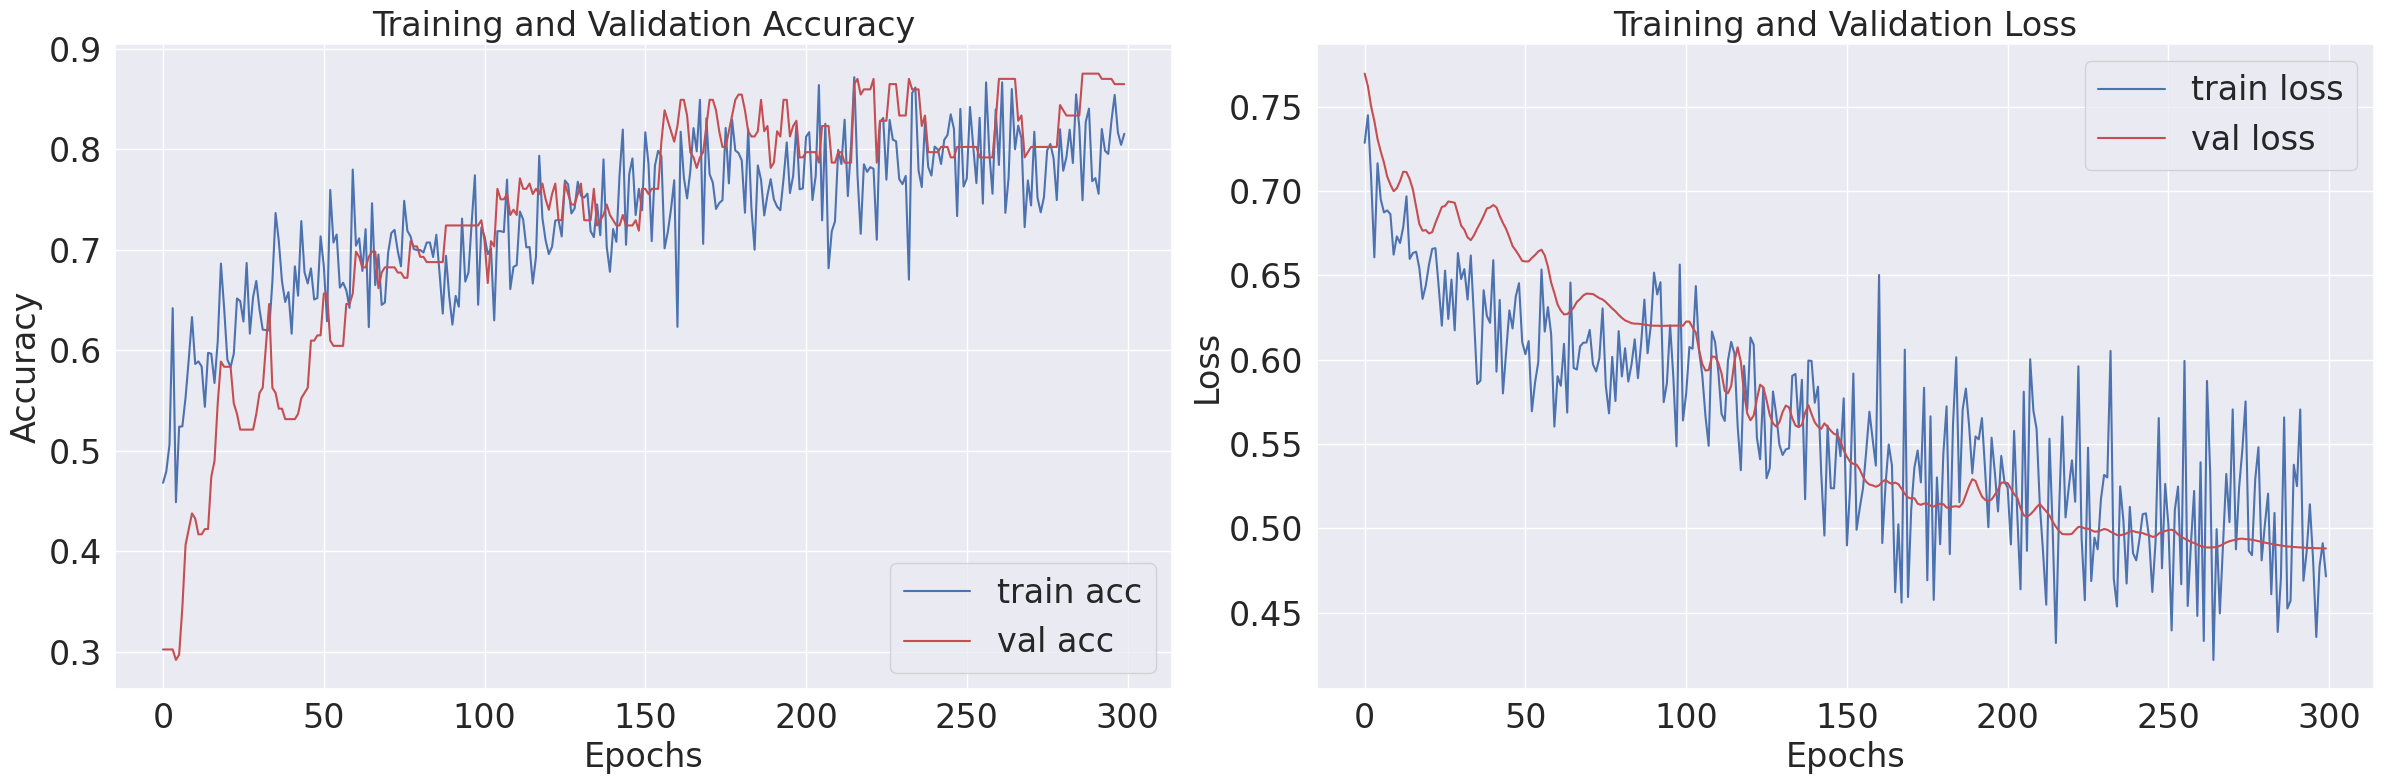

In [6]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


In [7]:
model_save_path = '/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint2'
torch.save(model.state_dict(), model_save_path)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.9228


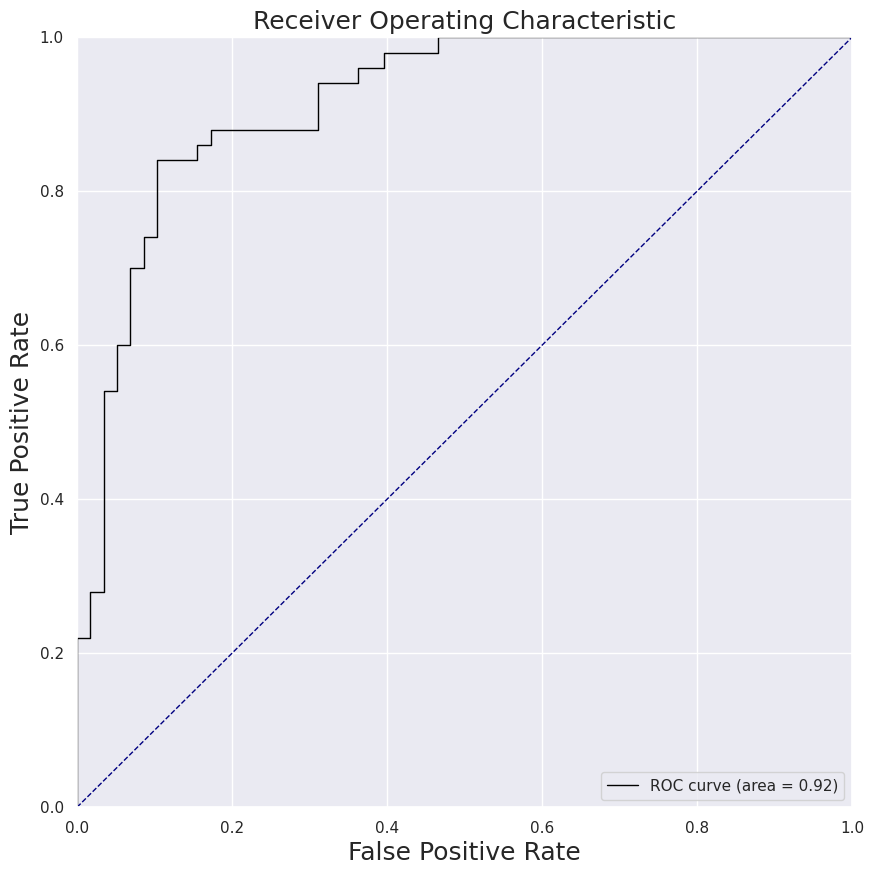

In [9]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [10]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/calibrated_model2.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

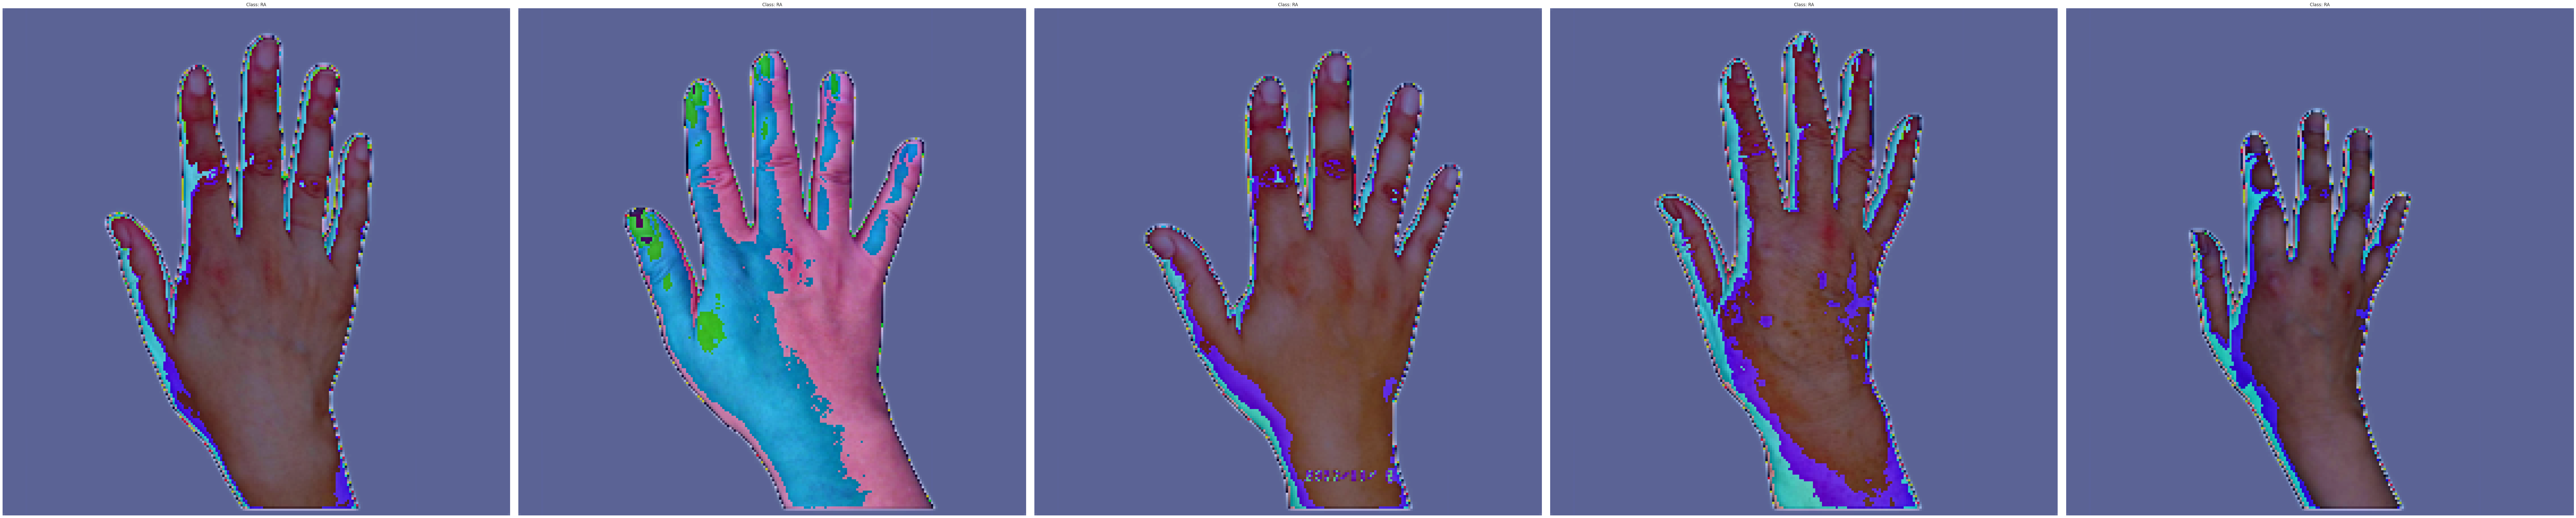

18285

In [19]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(100, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch

# 1. 予測と確信度の取得
def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    image_paths = []  # 画像のパスまたは画像自体を保存

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            image_paths.extend(images.cpu())  # または元の画像パス

    return np.array(predictions), np.array(true_labels), np.array(confidences), image_paths

# 2. 混同行列の作成と可視化
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 3. 誤分類サンプルの分析
def analyze_misclassifications(true_labels, predictions, confidences, image_paths, class_names):
    # 誤分類のインデックスを取得
    misclassified_idx = np.where(predictions != true_labels)[0]

    # 確信度でソート
    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    # 上位の誤分類ケースを表示
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < len(sorted_idx):
            mis_idx = sorted_idx[idx]
            image = image_paths[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            ax.imshow(image.permute(1, 2, 0))
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 4. 確信度分布の分析
def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(10, 6))

    # 正解と不正解の確信度を分離
    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メイン実行部分
def analyze_errors(model, val_loader, class_names, device):
    # 予測の取得
    predictions, true_labels, confidences, image_paths = get_predictions(model, val_loader, device)

    # 1. 全体の性能メトリクス
    print("Overall Accuracy:", np.mean(predictions == true_labels))

    # 2. 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 3. 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences,
                             image_paths, class_names)

    # 4. 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # 5. クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

<ipython-input-25-64a6b04253ed>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_check

Overall Accuracy: 0.926


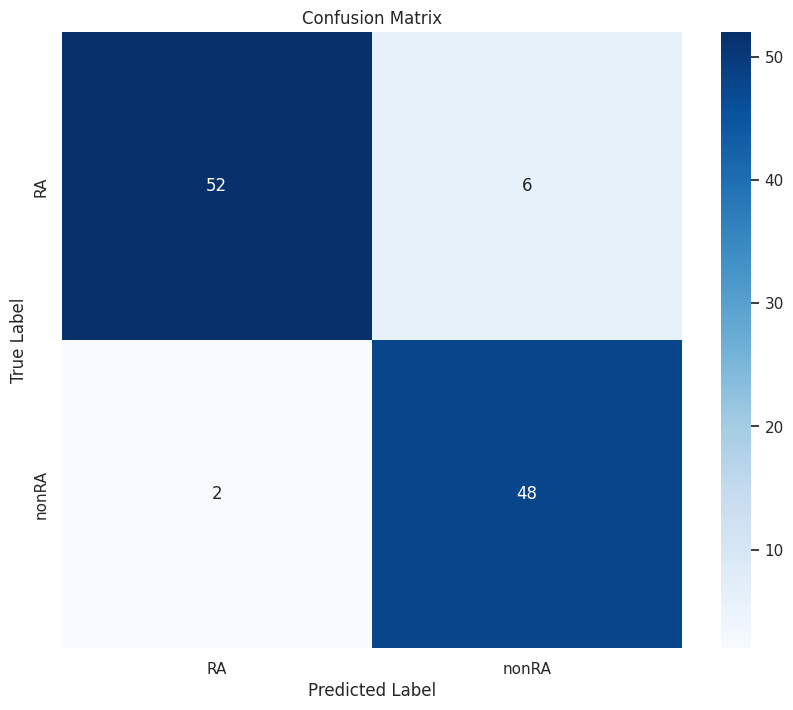

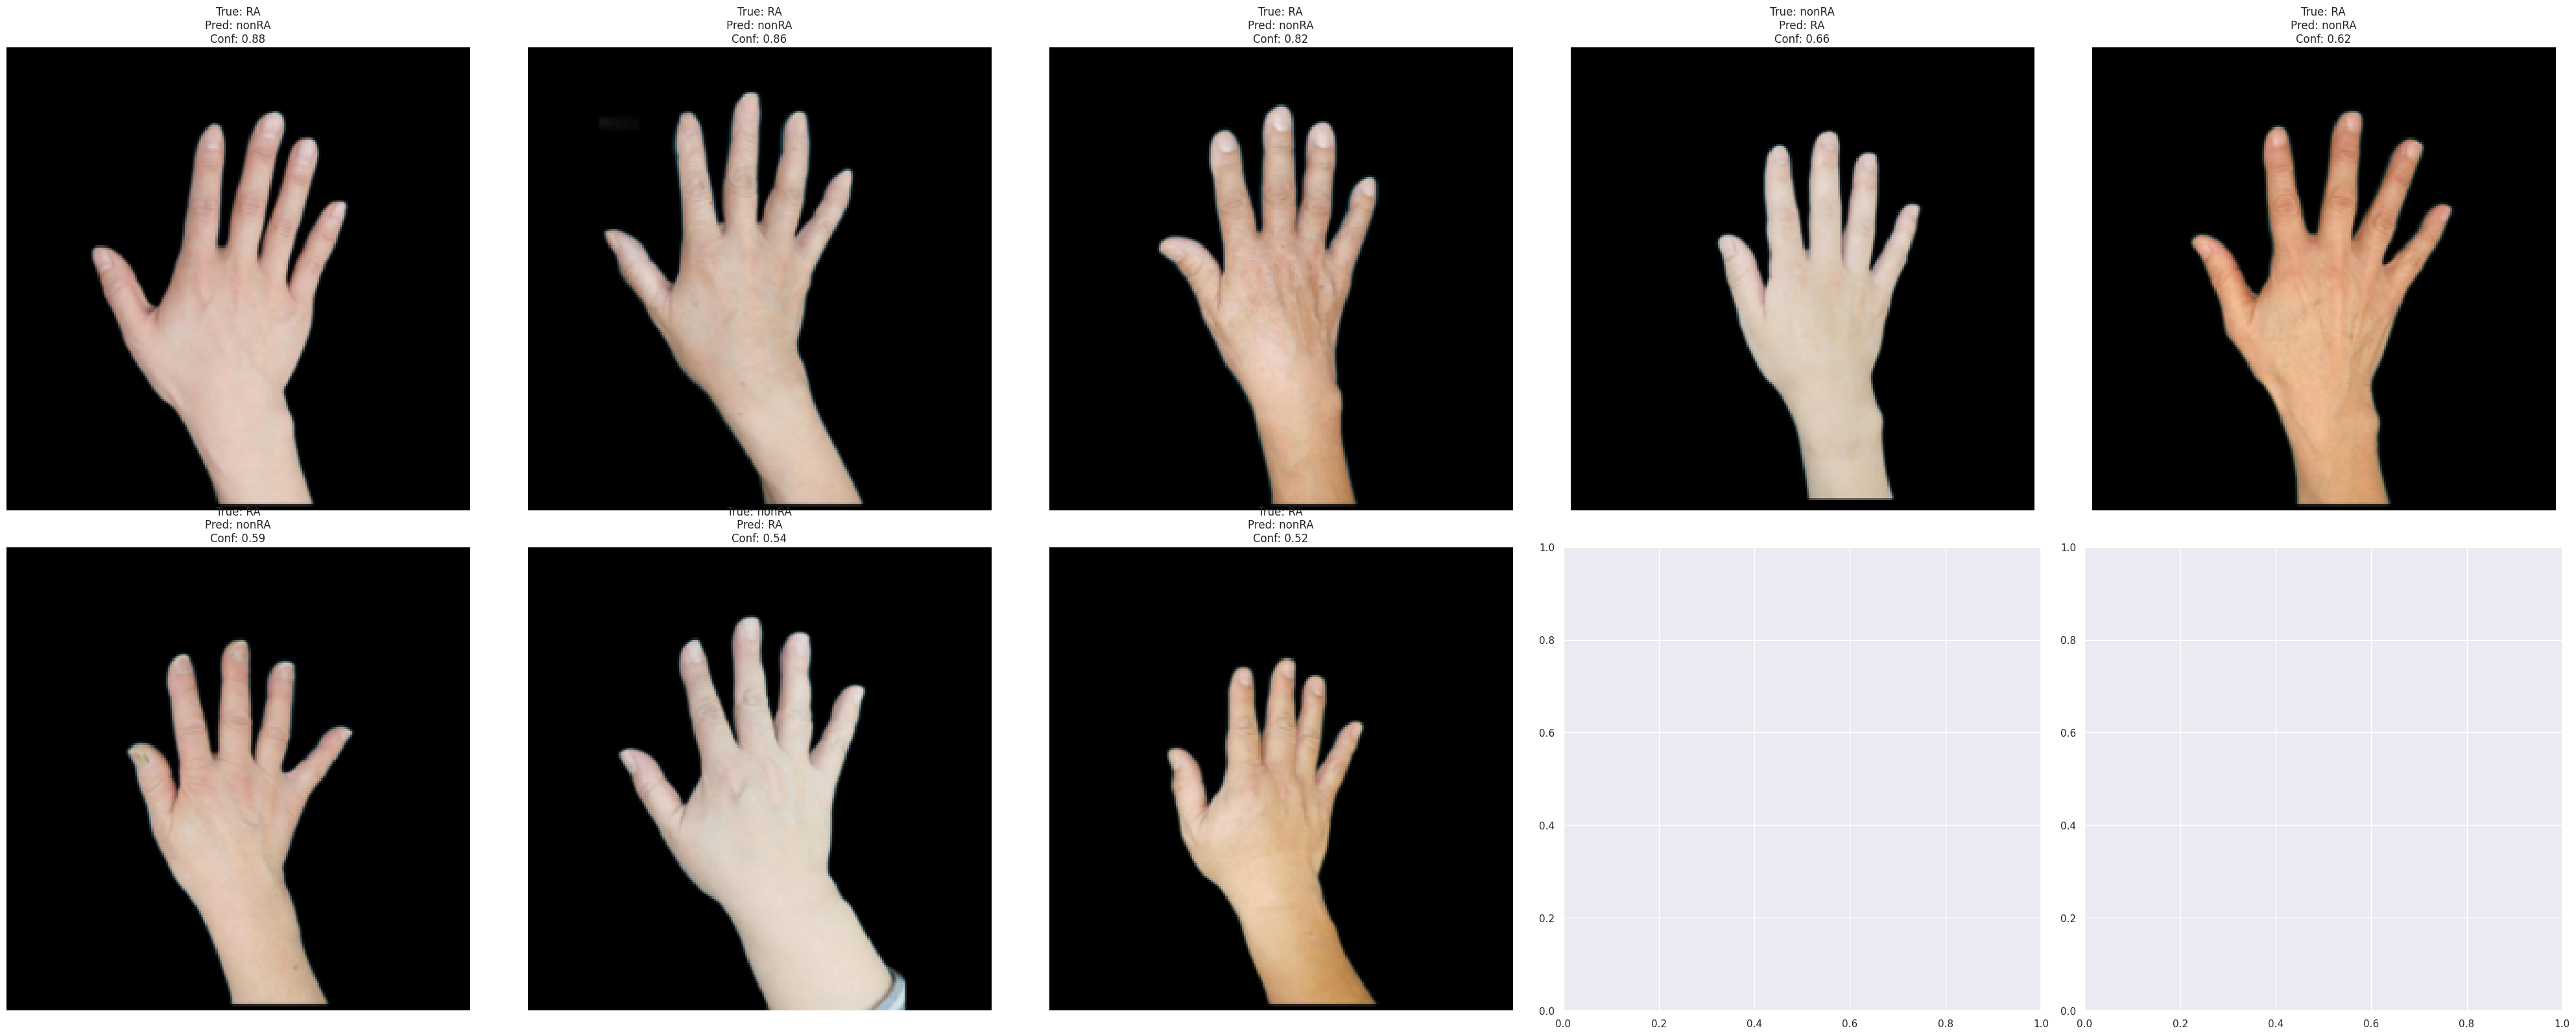

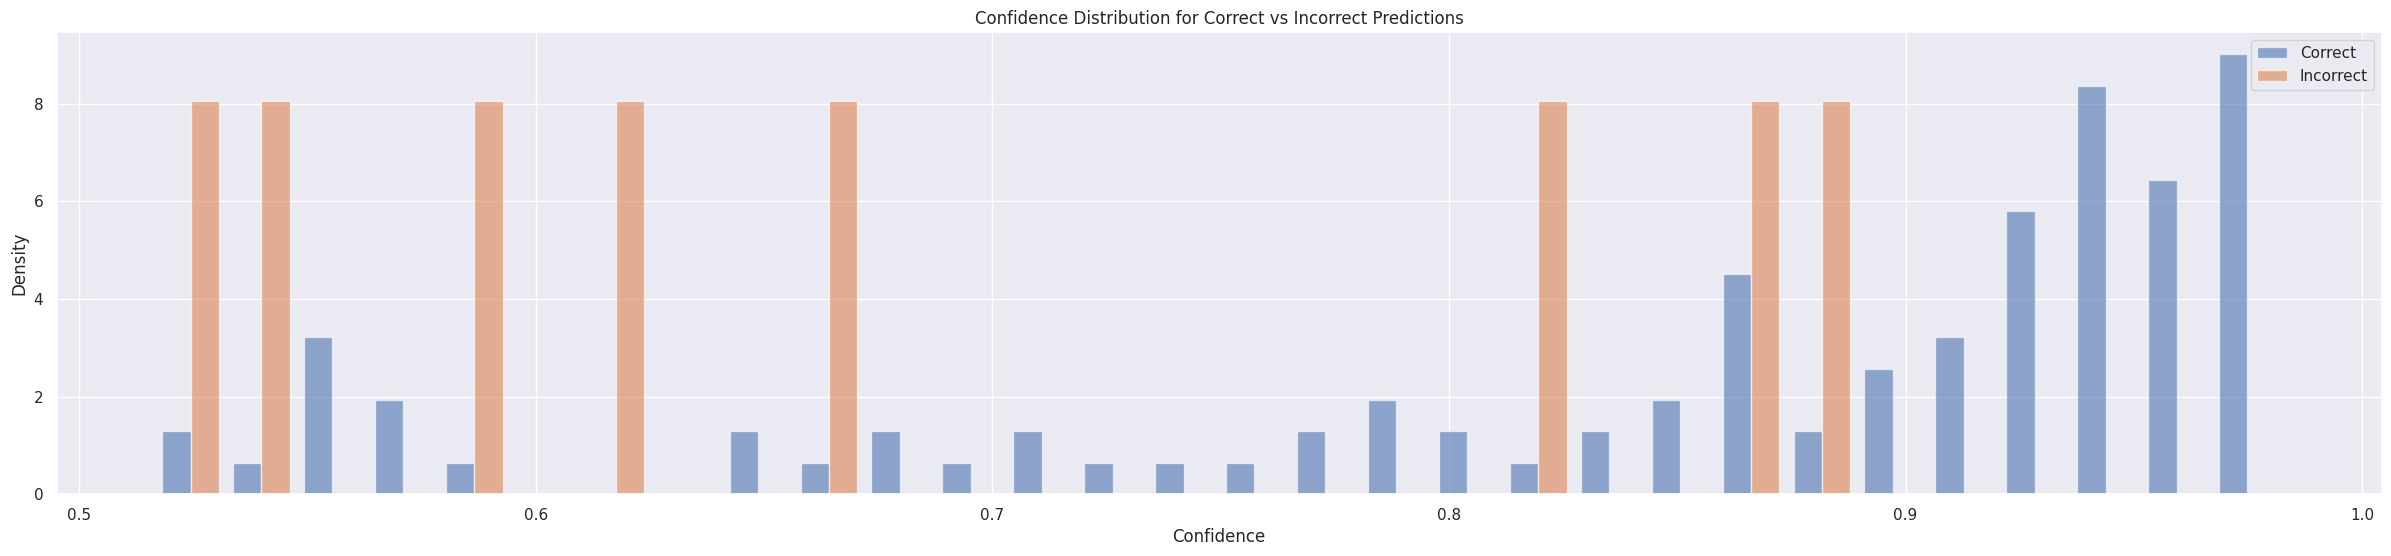


Class RA:
Accuracy: 0.897
Average confidence: 0.836
Samples: 58

Class nonRA:
Accuracy: 0.960
Average confidence: 0.836
Samples: 50


In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(40, 16))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(30, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()